In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df1 = pd.read_csv('churn-bigml-20.csv')
df = pd.read_csv('churn-bigml-80.csv')

In [3]:
def preprocess(df):
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  if 'churn' in df.columns:
    df['churn'] = df.churn.map({False:0, True:1})
  df['total_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls'] + df['total_intl_calls']
  df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] + df['total_intl_minutes']
  df['avg_call_duration'] = df['total_minutes'] / (df['total_calls'].replace(0,1))
  df['high_service_calls'] = (df['customer_service_calls'] > 3).astype(int)
  df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']
  df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes', 'total_minutes','total_eve_charge','total_day_charge'], axis= 1 , inplace= True)
  df.drop(["total_eve_calls", "total_night_calls", "total_calls", 'total_day_calls', "avg_call_duration", "area_code", "state" ], inplace= True, axis= 1)
  df['international_plan'] = df['international_plan'].map({'Yes': 1, 'No': 0})
  df['voice_mail_plan'] = df['voice_mail_plan'].map({'Yes': 1, 'No': 0})


  return df

In [4]:
df=preprocess(df)
df1=preprocess(df1)

     State  Account length  Area code International plan Voice mail plan  \
0       KS             128        415                 No             Yes   
1       OH             107        415                 No             Yes   
2       NJ             137        415                 No              No   
3       OH              84        408                Yes              No   
4       OK              75        415                Yes              No   
...    ...             ...        ...                ...             ...   
2661    SC              79        415                 No              No   
2662    AZ             192        415                 No             Yes   
2663    WV              68        415                 No              No   
2664    RI              28        510                 No              No   
2665    TN              74        415                 No             Yes   

      Number vmail messages  Total day minutes  Total day calls  \
0                   

In [5]:
df1.shape


(667, 11)

In [6]:
!pip install category_encoders
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , RobustScaler , StandardScaler , OrdinalEncoder , LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
from imblearn.combine import SMOTETomek


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
X=df.drop('churn',axis=1)
y=df['churn']
X_test=df1.drop('churn',axis=1)
y_test=df1['churn']

In [8]:
X.columns

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_night_charge', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls', 'high_service_calls',
       'total_charge'],
      dtype='object')

In [9]:
cat_columns = [ "voice_mail_plan", "international_plan" ]

num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'churn' in num_columns:
    num_columns.remove('churn')

In [10]:
# checking every models and its performnce

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB , MultinomialNB
from xgboost import XGBClassifier

In [11]:
models = [
        ("DT", DecisionTreeClassifier()) ,
        ("RF", RandomForestClassifier()),
        ("XGB", XGBClassifier()),
        ("SVM", SVC()),
        ("KNN", KNeighborsClassifier()),
]

In [12]:

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [13]:
# handling imbalancing data

from collections import Counter

print("Before:", Counter(y))
X_res, y_res = SMOTETomek(smote=SMOTE(sampling_strategy={1: 1820}, random_state=24)).fit_resample(X,y)
print("After SMOTETomek:", Counter(y_res))


Before: Counter({0: 2278, 1: 388})
After SMOTETomek: Counter({0: 2225, 1: 1767})


In [14]:
# scoring metrics for evaluation

scoring = {
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',  OrdinalEncoder(), cat_columns),
        ('num_scaling', RobustScaler(), num_columns )
    ],
    remainder='passthrough'
)

In [15]:
# ml pipeline for model selection

for model in models:
    # Build pipeline with preprocessing, SMOTETomek, and the model
    steps = [
   ('preprocessing', preprocessor),
   ("SmoteTomek", SMOTETomek(smote=SMOTE(sampling_strategy={1: 1820}, random_state=24))),
   (model)
]

    pipeline = Pipeline(steps= steps)  # Apply all pipeline steps and saved to use in CV

     # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
    result = cross_validate(pipeline, X_res, y_res, cv= skf, scoring= scoring, return_train_score= True)

    # Average recall
    print(f"{model[0]} Average Train Recall: {result['train_recall'].mean():.4f}")
    print(f"{model[0]} Average Test Recall: {result['test_recall'].mean():.4f}")

    # Average accuracy
    print(f"{model[0]} Average Train Accuracy: {result['train_accuracy'].mean():.4f}")
    print(f"{model[0]} Average Test Accuracy: {result['test_accuracy'].mean():.4f}")

    # Average precision
    print(f"{model[0]} Average Train Precision: {result['train_precision'].mean():.4f}")
    print(f"{model[0]} Average Test Precision: {result['test_precision'].mean():.4f}\n")

DT Average Train Recall: 0.9786
DT Average Test Recall: 0.8648
DT Average Train Accuracy: 0.9857
DT Average Test Accuracy: 0.8690
DT Average Train Precision: 0.9890
DT Average Test Precision: 0.8435

RF Average Train Recall: 0.9731
RF Average Test Recall: 0.8466
RF Average Train Accuracy: 0.9864
RF Average Test Accuracy: 0.9178
RF Average Train Precision: 0.9961
RF Average Test Precision: 0.9634

XGB Average Train Recall: 0.9782
XGB Average Test Recall: 0.8614
XGB Average Train Accuracy: 0.9868
XGB Average Test Accuracy: 0.9118
XGB Average Train Precision: 0.9920
XGB Average Test Precision: 0.9343

SVM Average Train Recall: 0.7305
SVM Average Test Recall: 0.7170
SVM Average Train Accuracy: 0.7489
SVM Average Test Accuracy: 0.7402
SVM Average Train Precision: 0.7104
SVM Average Test Precision: 0.7025

KNN Average Train Recall: 0.9321
KNN Average Test Recall: 0.8715
KNN Average Train Accuracy: 0.8924
KNN Average Test Accuracy: 0.8324
KNN Average Train Precision: 0.8419
KNN Average Test P

In [16]:
# chossing random forest as final model

# pipline with our final model
steps = [
     ('preprocessing', preprocessor),
     ("SmoteTomek", SMOTETomek(smote=SMOTE(sampling_strategy={1: 1820}, random_state=24))),
     ("RF" ,  RandomForestClassifier())
]

pipeline = Pipeline(steps= steps)

In [17]:
#handling Overfitting

param_grid = {
    'RF__n_estimators': [180, 200, 250],
    'RF__max_depth': [9 , 10,  11],
    'RF__min_samples_split': [ 16 , 14 ,18],
    'RF__min_samples_leaf': [2, 4, 6]
}

scorers = {
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score)
}

# Cross validation + GridSearchCV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
grid = GridSearchCV( estimator= pipeline, param_grid= param_grid, cv= skf, scoring= scorers, refit='recall',  return_train_score= True )


result = grid.fit(X_res, y_res)

In [18]:
print(
    # Acc
    f"Train Acc: {result.cv_results_['mean_train_accuracy'][result.best_index_]:.4f} | "
    f"Test Acc: {result.cv_results_['mean_test_accuracy'][result.best_index_]:.4f} | "

    # recall
    f"Train Recall: {result.cv_results_['mean_train_recall'][result.best_index_]:.4f} | "
    f"Test Recall: {result.cv_results_['mean_test_recall'][result.best_index_]:.4f} | "

      # Precision
    f"Train Precision: {result.cv_results_['mean_train_precision'][result.best_index_]:.4f} | "
    f"Test Precision: {result.cv_results_['mean_test_precision'][result.best_index_]:.4f}"
)

Train Acc: 0.9218 | Test Acc: 0.8900 | Train Recall: 0.8319 | Test Recall: 0.7765 | Train Precision: 0.9898 | Test Precision: 0.9691


In [19]:
pipeline.set_params(**result.best_params_)

,steps,"[('preprocessing', ...), ('SmoteTomek', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num_scaling', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
Final_Model = pipeline.fit(X_res, y_res)

In [21]:
y_pred =Final_Model.predict(X_test)

# 6. EVALUATION METRICS
acc = accuracy_score(y_test, y_pred)
print(f"\n Model Accuracy: {acc:.2%}")
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))


 Model Accuracy: 97.60%

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       572
           1       0.95      0.87      0.91        95

    accuracy                           0.98       667
   macro avg       0.97      0.93      0.95       667
weighted avg       0.98      0.98      0.98       667



In [22]:
import seaborn as sns

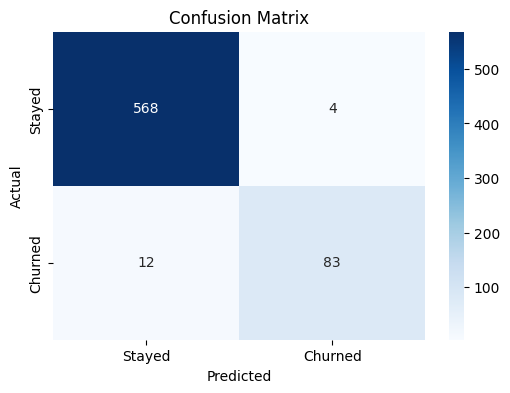

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
import joblib
joblib.dump(Final_Model, "final_model.pkl")


['final_model.pkl']

In [2]:
import pandas as pd
test_data='churn-bigml-20.csv'
pred_df=pd.read_csv(test_data)
new=pred_df.drop(['Churn'],axis=1)
new

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,WI,114,415,No,Yes,26,137.1,88,23.31,155.7,125,13.23,247.6,94,11.14,11.5,7,3.11,2
663,AL,106,408,No,Yes,29,83.6,131,14.21,203.9,131,17.33,229.5,73,10.33,8.1,3,2.19,1
664,VT,60,415,No,No,0,193.9,118,32.96,85.0,110,7.23,210.1,134,9.45,13.2,8,3.56,3
665,WV,159,415,No,No,0,169.8,114,28.87,197.7,105,16.80,193.7,82,8.72,11.6,4,3.13,1


In [3]:
def preprocess(df):
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  if 'churn' in df.columns:
    df['churn'] = df.churn.map({False:0, True:1})
  df['total_calls'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls'] + df['total_intl_calls']
  df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] + df['total_intl_minutes']
  df['avg_call_duration'] = df['total_minutes'] / (df['total_calls'].replace(0,1))
  df['high_service_calls'] = (df['customer_service_calls'] > 3).astype(int)
  df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']
  df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes', 'total_minutes','total_eve_charge','total_day_charge'], axis= 1 , inplace= True)
  df.drop(["total_eve_calls", "total_night_calls", "total_calls", 'total_day_calls', "avg_call_duration", "area_code", "state" ], inplace= True, axis= 1)
  df['international_plan'] = df['international_plan'].map({'Yes': 1, 'No': 0})
  df['voice_mail_plan'] = df['voice_mail_plan'].map({'Yes': 1, 'No': 0})


  return df

In [5]:
new_df=preprocess(new)
new_df

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,high_service_calls,total_charge
0,117,0,0,0,9.71,4,2.35,1,0,73.32
1,65,0,0,0,9.40,6,3.43,4,1,54.20
2,161,0,0,0,7.23,9,1.46,4,1,92.29
3,111,0,0,0,8.53,6,2.08,2,0,41.05
4,49,0,0,0,8.04,1,3.00,1,0,49.60
...,...,...,...,...,...,...,...,...,...,...
662,114,0,1,26,11.14,7,3.11,2,0,50.79
663,106,0,1,29,10.33,3,2.19,1,0,44.06
664,60,0,0,0,9.45,8,3.56,3,0,53.20
665,159,0,0,0,8.72,4,3.13,1,0,57.52


In [10]:
import joblib
model = joblib.load("final_model.pkl")
processed_data=new_df.copy()
churn_prediction=model.predict(processed_data)
results_df = pred_df.copy()
results_df['predicted_churn_class'] = churn_prediction
results_df['predicted_churn_label'] = results_df['predicted_churn_class'].map({
    0: 'Will Not Churn',
    1: 'Will Churn'
})
print(results_df)

     account_length  international_plan  voice_mail_plan  \
0               117                   0                0   
1                65                   0                0   
2               161                   0                0   
3               111                   0                0   
4                49                   0                0   
..              ...                 ...              ...   
662             114                   0                1   
663             106                   0                1   
664              60                   0                0   
665             159                   0                0   
666             184                   1                0   

     number_vmail_messages  total_night_charge  total_intl_calls  \
0                        0                9.71                 4   
1                        0                9.40                 6   
2                        0                7.23                 9   
3      

In [11]:
results_df.to_csv("result2.csv",index=False)